In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.io
import random
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
meta = pd.read_csv("meta_processed.csv")

In [3]:
meta

,Age,ER_Status,PR_Status,HER2_Status,Grade,T_Stage,N_Stage,PAM50_Class,DRFS_Event,DRFS_Year,ChemoEncoding
0,44.0,positive,positive,negative,2.0,T3,N0,unknown,unknown,NaN,0
1,43.0,positive,positive,negative,unknown,T4,N1,unknown,unknown,NaN,0
2,56.0,negative,negative,negative,3,T4,N3,unknown,unknown,cat1,0
3,41.0,positive,negative,negative,2,T2,N1,unknown,unknown,cat3,0
4,39.0,positive,positive,negative,3.0,T2,N1,unknown,unknown,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
1166,46.0,negative,negative,positive,3.0,T3,unknown,unknown,unknown,NaN,1
1167,62.0,positive,positive,negative,3,T4,N1,unknown,unknown,cat1,0
1168,44.0,positive,negative,negative,2.0,T2,unknown,unknown,unknown,NaN,0
1169,38.0,positive,positive,negative,3,T4,N1,unknown,unknown,cat3,0


In [4]:
print(meta.isna().any())

Age              False
ER_Status        False
PR_Status        False
HER2_Status      False
Grade            False
T_Stage          False
N_Stage          False
PAM50_Class      False
DRFS_Event       False
DRFS_Year         True
ChemoEncoding    False
dtype: bool


In [5]:
meta["DRFS_Year"] = meta["DRFS_Year"].fillna("unknown")

In [6]:
print(meta.isna().any())

Age              False
ER_Status        False
PR_Status        False
HER2_Status      False
Grade            False
T_Stage          False
N_Stage          False
PAM50_Class      False
DRFS_Event       False
DRFS_Year        False
ChemoEncoding    False
dtype: bool


In [7]:
print(meta.dtypes)

Age              float64
ER_Status         object
PR_Status         object
HER2_Status       object
Grade             object
T_Stage           object
N_Stage           object
PAM50_Class       object
DRFS_Event        object
DRFS_Year         object
ChemoEncoding      int64
dtype: object


### Upsampling

In [8]:
from imblearn.over_sampling import RandomOverSampler

# create an instance of RandomOverSampler
ros = RandomOverSampler()

# separate the features and target variable from the dataframe
X = meta.drop('ChemoEncoding', axis=1)
y = meta['ChemoEncoding']

# fit and apply the oversampling to the dataset
X_resampled, y_resampled = ros.fit_resample(X, y)

In [9]:
value_counts = y_resampled.value_counts()
value_counts

0    933
1    933
Name: ChemoEncoding, dtype: int64

In [10]:
X_resampled

,Age,ER_Status,PR_Status,HER2_Status,Grade,T_Stage,N_Stage,PAM50_Class,DRFS_Event,DRFS_Year
0,44.0,positive,positive,negative,2.0,T3,N0,unknown,unknown,unknown
1,43.0,positive,positive,negative,unknown,T4,N1,unknown,unknown,unknown
2,56.0,negative,negative,negative,3,T4,N3,unknown,unknown,cat1
3,41.0,positive,negative,negative,2,T2,N1,unknown,unknown,cat3
4,39.0,positive,positive,negative,3.0,T2,N1,unknown,unknown,unknown
...,...,...,...,...,...,...,...,...,...,...
1861,40.0,positive,positive,negative,3,T3,N1,unknown,unknown,cat3
1862,51.0,negative,negative,positive,3.0,T4,unknown,unknown,unknown,unknown
1863,57.0,negative,negative,negative,3,T2,N1,unknown,unknown,cat2
1864,50.0,negative,negative,negative,unknown,T2,unknown,unknown,unknown,unknown


In [11]:
### redo Chi square Stas
from scipy.stats import chi2_contingency

# Create an empty list to store the results of the chi-square tests
results = []

# Loop through all predictor columns (excluding the first column "age" and the last column "ChemoEncoding")
for col in X_resampled.columns[1:]:
    # Create a contingency table with the predictor variable and response variable
    contingency_table = pd.crosstab(meta[col], meta["ChemoEncoding"])
    
    
    # Perform chi-square test and extract the p-value
    _, p_value, _, _ = chi2_contingency(contingency_table)
    
    # Append the predictor variable name and p-value to the results list
    results.append((col, p_value))

# Sort the results list by p-value in ascending order
results.sort(key=lambda x: x[1])

# Print the results
for col, p_value in results:
    if p_value < 0.05:  # Set a significance threshold of 0.05
        print(f"{col}: p-value = {p_value:.4f} (significant)")
    else:
        print(f"{col}: p-value = {p_value:.4f}")

ER_Status: p-value = 0.0000 (significant)
PR_Status: p-value = 0.0000 (significant)
Grade: p-value = 0.0000 (significant)
HER2_Status: p-value = 0.0002 (significant)
T_Stage: p-value = 0.3154
N_Stage: p-value = 0.7054
DRFS_Year: p-value = 0.7915
PAM50_Class: p-value = 1.0000
DRFS_Event: p-value = 1.0000


In [12]:
print(X_resampled.dtypes)

Age            float64
ER_Status       object
PR_Status       object
HER2_Status     object
Grade           object
T_Stage         object
N_Stage         object
PAM50_Class     object
DRFS_Event      object
DRFS_Year       object
dtype: object


In [13]:
# one hat encoding
age = X_resampled['Age']
X_categorical = X_resampled.drop('Age', axis=1)

# apply one-hot encoding to the categorical features
X_encoded = pd.get_dummies(X_categorical)

# merge the one-hot encoded features with the 'Age' column
X_resampled_encoded = pd.concat([age, X_encoded], axis=1)

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled_encoded, y_resampled, test_size=0.2, random_state=17)

In [37]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score

# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)
logreg_acc = accuracy_score(y_test, logreg_pred)

print("Accuracy Scores:")
print("Logistic Regression:", logreg_acc)
print(0.7531914893617021)

Accuracy Scores:
Logistic Regression: 0.6550802139037433
0.7531914893617021


sensitivity:  0.703125
specificity: 0.6043956043956044


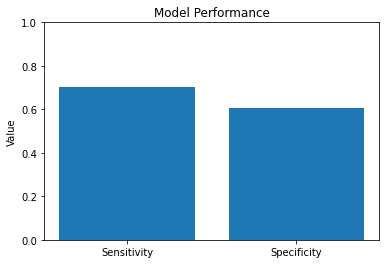

In [38]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Assume y_true and y_pred are the true and predicted labels, respectively
tn, fp, fn, tp = confusion_matrix(y_test, logreg_pred).ravel()

# Compute sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
# print
print("sensitivity: ",sensitivity)
print("specificity:", specificity)
# Visualize the results
fig, ax = plt.subplots()
ax.bar(["Sensitivity", "Specificity"], [sensitivity, specificity])
ax.set_ylim([0, 1])
ax.set_ylabel("Value")
ax.set_title("Model Performance")
plt.show()

In [39]:
# random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# train a random forest classifier with 100 trees
rfc = RandomForestClassifier(n_estimators=100, random_state=42,max_depth=10)
rfc.fit(X_train, y_train)

# make predictions on the test set
y_pred = rfc.predict(X_test)

# calculate the accuracy score
acc_score = accuracy_score(y_test, y_pred)
print("Accuracy score: ", acc_score)

Accuracy score:  0.8422459893048129


sensitivity:  0.921875
specificity: 0.7582417582417582


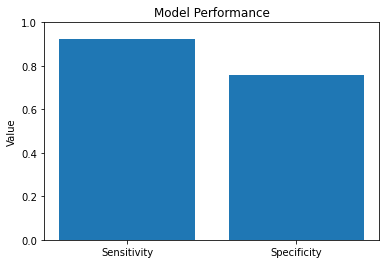

In [40]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Assume y_true and y_pred are the true and predicted labels, respectively
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Compute sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
# print
print("sensitivity: ",sensitivity)
print("specificity:", specificity)
# Visualize the results
fig, ax = plt.subplots()
ax.bar(["Sensitivity", "Specificity"], [sensitivity, specificity])
ax.set_ylim([0, 1])
ax.set_ylabel("Value")
ax.set_title("Model Performance")
plt.show()

### Hash encoding

In [19]:
# hush encoding 
X_hash = X_resampled
for col in X_hash.columns[1:]:
    X_hash[col] = X_hash[col].apply(hash)

In [20]:
X_hash

,Age,ER_Status,PR_Status,HER2_Status,Grade,T_Stage,N_Stage,PAM50_Class,DRFS_Event,DRFS_Year
0,44.0,-750268770708301999,-750268770708301999,6128989376204138304,-2187650197158960794,-8785271258074182329,-6022439852372967130,7391757792801287780,7391757792801287780,7391757792801287780
1,43.0,-750268770708301999,-750268770708301999,6128989376204138304,7391757792801287780,-6372219549247769520,3856135713783899016,7391757792801287780,7391757792801287780,7391757792801287780
2,56.0,6128989376204138304,6128989376204138304,6128989376204138304,3925692415825816786,-6372219549247769520,6867988391694828766,7391757792801287780,7391757792801287780,-234544340340559663
3,41.0,-750268770708301999,6128989376204138304,6128989376204138304,-4946417570990836277,-2888796564497152829,3856135713783899016,7391757792801287780,7391757792801287780,6680069120268132979
4,39.0,-750268770708301999,-750268770708301999,6128989376204138304,6398946381193796244,-2888796564497152829,3856135713783899016,7391757792801287780,7391757792801287780,7391757792801287780
...,...,...,...,...,...,...,...,...,...,...
1861,40.0,-750268770708301999,-750268770708301999,6128989376204138304,3925692415825816786,-8785271258074182329,3856135713783899016,7391757792801287780,7391757792801287780,6680069120268132979
1862,51.0,6128989376204138304,6128989376204138304,-750268770708301999,6398946381193796244,-6372219549247769520,7391757792801287780,7391757792801287780,7391757792801287780,7391757792801287780
1863,57.0,6128989376204138304,6128989376204138304,6128989376204138304,3925692415825816786,-2888796564497152829,3856135713783899016,7391757792801287780,7391757792801287780,-1962245467161721315
1864,50.0,6128989376204138304,6128989376204138304,6128989376204138304,7391757792801287780,-2888796564497152829,7391757792801287780,7391757792801287780,7391757792801287780,7391757792801287780


In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_hash, y_resampled, test_size=0.2, random_state=42)

In [22]:
# random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# train a random forest classifier with 100 trees
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

# make predictions on the test set
y_pred = rfc.predict(X_test)

# calculate the accuracy score
acc_score = accuracy_score(y_test, y_pred)
print("Accuracy score: ", acc_score)

Accuracy score:  0.9064171122994652


sensitivity:  0.9625668449197861
specificity: 0.8502673796791443


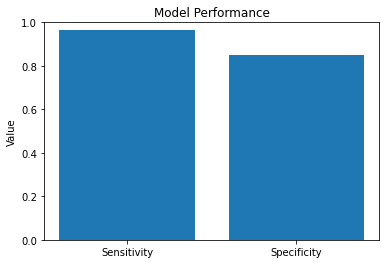

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Assume y_true and y_pred are the true and predicted labels, respectively
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Compute sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
# print
print("sensitivity: ",sensitivity)
print("specificity:", specificity)
# Visualize the results
fig, ax = plt.subplots()
ax.bar(["Sensitivity", "Specificity"], [sensitivity, specificity])
ax.set_ylim([0, 1])
ax.set_ylabel("Value")
ax.set_title("Model Performance")
plt.show()

In [42]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# assuming X_resampled_encoded is the one-hot encoded feature matrix
# and y_resampled is the target variable
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=15)

rfc = RandomForestClassifier(n_estimators=100, random_state=15)
acc_scores = []

for train_index, test_index in kf.split(X_resampled_encoded):
    X_train, X_test = X_resampled_encoded.iloc[train_index], X_resampled_encoded.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)
    print(acc_score)
    acc_scores.append(acc_score)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    # print
    print("sensitivity: ",sensitivity)
    print("specificity:", specificity)
    
mean_acc_score = sum(acc_scores) / n_splits
print("Mean accuracy score: ", mean_acc_score)


0.9197860962566845
sensitivity:  0.9705882352941176
specificity: 0.8588235294117647
0.9411764705882353
sensitivity:  0.9801980198019802
specificity: 0.8953488372093024
0.8609625668449198
sensitivity:  0.9484536082474226
specificity: 0.7666666666666667
0.8449197860962567
sensitivity:  0.9651162790697675
specificity: 0.7425742574257426
0.9144385026737968
sensitivity:  0.9880952380952381
specificity: 0.8543689320388349
0.9251336898395722
sensitivity:  0.9591836734693877
specificity: 0.8876404494382022
0.8655913978494624
sensitivity:  0.945054945054945
specificity: 0.7894736842105263
0.9247311827956989
sensitivity:  0.9891304347826086
specificity: 0.8617021276595744
0.8763440860215054
sensitivity:  1.0
specificity: 0.7415730337078652
0.8870967741935484
sensitivity:  0.9882352941176471
specificity: 0.801980198019802
Mean accuracy score:  0.8960180553159679
